In [2]:
#!/usr/bin/env python
"""greedyUP.py
    Script baseado no código original em  https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/"""
__author__ = "Filipe Rodrigues"
__credits__ = ["https://machinelearningmastery.com/greedy-layer-wise-pretraining-tutorial/"]
__version__ = "1.0"
__maintainer__ = "Filipe Rodrigues"
__email__ = "frodriguesfajr@gmail.com"
__status__ = "Production"


In [3]:
import sys
print('Versão python: ' + sys.version)

Versão python: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [4]:
import tensorflow as tf
print('Versão TensorFlow: ' + tf.__version__)

Versão TensorFlow: 2.17.1


In [5]:
import keras
print('Versão keras: ' + keras.__version__)

Versão keras: 3.5.0


In [ ]:
import tensorflow as tf
print('Versão TensorFlow: ' + tf.__version__)
# Verifique as GPUs disponíveis
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Ativar o crescimento de memória para a primeira GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)

        # (Opcional) Definir uma GPU específica, caso tenha mais de uma
        # tf.config.set_visible_devices(gpus[0], 'GPU')  # Descomente se necessário

        print("Configuração de GPU aplicada com sucesso!")
    except RuntimeError as e:
        print(f"Erro ao configurar a memória da GPU: {e}")
else:
    print("Nenhuma GPU disponível.")

Configuração de GPU aplicada com sucesso!


In [10]:
pip install visualkeras

In [11]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np
import visualkeras
# Desativar certas opções de otimização e logs do TensorFlow
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 42.7 MB/s eta 0:00:00


In [12]:
from utils_greedy import prepare_data, base_autoencoder
from utils_greedy import evaluate_autoencoder_as_classifier, add_layer_to_autoencoder

Versão do keras: 3.5.0


### Unsupervised Greedy Layer-Wise Pretraining
Vamos explorar o uso do pré-treinamento ganancioso em camadas com um modelo não supervisionado.

Especificamente, desenvolveremos um modelo autocodificador que será treinado para reconstruir dados de entrada.

Para usar esse modelo não supervisionado para classificação, removeremos a camada de saída, adicionaremos e ajustaremos uma nova camada de saída para classificação.

O primeiro passo é definir, ajustar e avaliar um modelo autocodificador. Usaremos o mesmo modelo base de duas camadas que usamos na seção anterior, exceto modificá-lo para prever a entrada como a saída e usar o erro quadrático médio para avaliar o quão bom o modelo é na reconstrução de uma determinada amostra de entrada.

A função base_autoencoder() abaixo implementa isso, tomando os conjuntos de treinamento e teste como argumentos, então define, ajusta e avalia o modelo base do autoencoder não supervisionado, imprimindo o erro de reconstrução
nos conjuntos de treinamento e teste e retornando o modelo.


In [13]:
# Gerar dataset de blobs gaussianos isotrópicos para classificação 2D com 3 centros
x, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# Preparação dados
trainX, testX, trainy, testy = prepare_data(x, y)

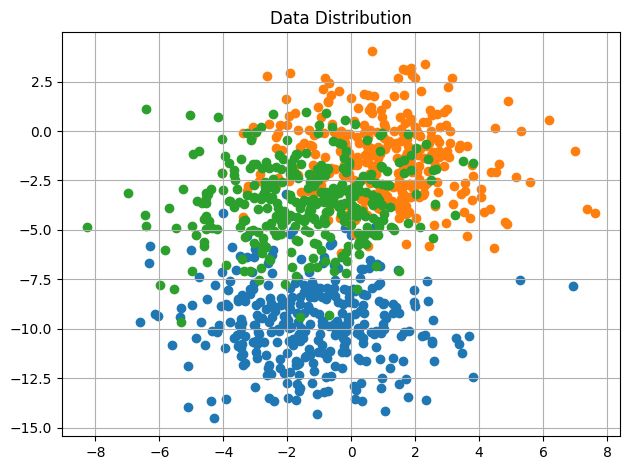

In [14]:
# scatter plot para cada classe de valor
for class_value in range(3):
    # select indices of points with the class label
    row_ix = np.where(y == class_value)
    # scatter plot for points with a different color
    plt.scatter(x[row_ix, 0], x[row_ix, 1])
# Mostrar o plot
plt.title("Data Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# # Função base_autoencoder para adicionar e treinar camadas.
model = base_autoencoder(trainX, testX)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


> reconstruction error train=0.000, test=0.000


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              22 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106 (428.00 B)

 Trainable params: 52 (208.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54 (220.00 B)

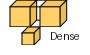

In [19]:
visualkeras.layered_view(model, legend=True) # without custom font

In [20]:
# Função evaluate_autoencoder_as_classifier que pega o modelo, os conjuntos de treinamento e teste, para retornar a
# precisão da classificação do conjunto de treinamento e teste.
scores_loss = dict()
scores_acc = dict()
train_loss, test_loss, train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
print('> classifier accuracy layers=%d, train_loss=%.3f, test_loss=%.3f, train_acc=%.3f, test_acc=%.3f'
       % (len(model.layers),  train_loss, test_loss, train_acc, test_acc))
scores_loss[len(model.layers)] = (train_loss, test_loss)
scores_acc[len(model.layers)] = (train_acc, test_acc)

> classifier accuracy layers=2, train_loss=0.422, test_loss=0.411, train_acc=0.820, test_acc=0.838


In [21]:
# Definição do processo para adicionar e pré-treinar camadas ao modelo.
# A função add_layer_to_autoencoder() abaixo adiciona uma nova camada oculta ao modelo do autoencoder,
# atualiza os pesos para a nova camada e as camadas ocultas e, em seguida, aponta o erro de reconstrução nos dados
# de entrada dos conjuntos de treinamento e teste.
n_layers = 4
for _ in range(n_layers):
	# add layer
	add_layer_to_autoencoder(model, trainX, testX)
	# evaluate model
	train_loss, test_loss, train_acc, test_acc  = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
	# print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	print('> classifier accuracy layers=%d, train_loss=%.3f, test_loss=%.3f, train_acc=%.3f, test_acc=%.3f'
       % (len(model.layers),  train_loss, test_loss, train_acc, test_acc))
	# store scores for plotting
	scores_loss[len(model.layers)] = (train_loss, test_loss)
	scores_acc[len(model.layers)] = (train_acc, test_acc)

> reconstruction error train=0.000, test=0.001
> classifier accuracy layers=3, train_loss=0.421, test_loss=0.410, train_acc=0.824, test_acc=0.834
> reconstruction error train=0.002, test=0.004
> classifier accuracy layers=4, train_loss=0.421, test_loss=0.414, train_acc=0.834, test_acc=0.834
> reconstruction error train=0.005, test=0.010
> classifier accuracy layers=5, train_loss=0.421, test_loss=0.414, train_acc=0.824, test_acc=0.838
> reconstruction error train=2.209, test=2.457
> classifier accuracy layers=6, train_loss=0.503, test_loss=0.489, train_acc=0.766, test_acc=0.778


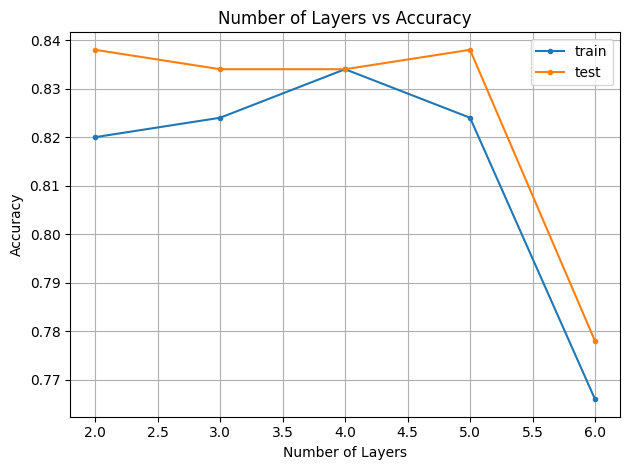

In [23]:
# Plot número de camadas adicionadas vs acurácia
keys = list(scores_acc.keys())
plt.plot(keys, [scores_acc[k][0] for k in keys], label='train', marker='.')
plt.plot(keys, [scores_acc[k][1] for k in keys], label='test', marker='.')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Number of Layers vs Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

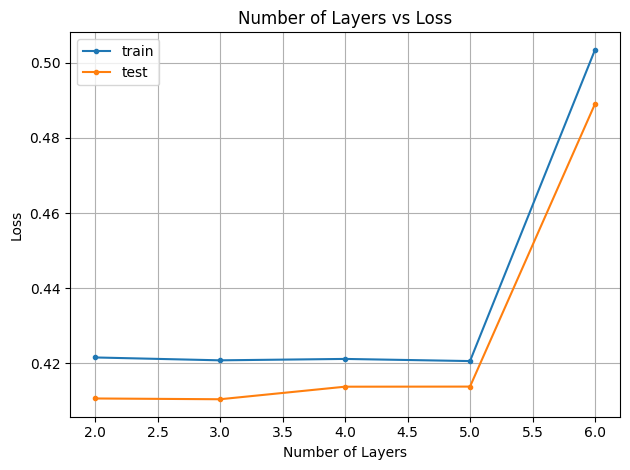

In [24]:
# Plot número de camadas adicionadas vs Loss
keys = list(scores_loss.keys())
plt.plot(keys, [scores_loss[k][0] for k in keys], label='train', marker='.')
plt.plot(keys, [scores_loss[k][1] for k in keys], label='test', marker='.')
plt.legend()
plt.xlabel("Number of Layers")
plt.ylabel("Loss")
plt.title("Number of Layers vs Loss")
plt.grid(True)
plt.tight_layout()
plt.show()